In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="custom.css">

In [2]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.charts import Bar, Line
from bokeh.plotting import figure
from bokeh.palettes import Category10 as palette
from bokeh.io import push_notebook, show, output_notebook
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (11, 5)
output_notebook()
np.random.seed(1)
import warnings
warnings.simplefilter('ignore')

/home/adrian/.virtualenvs/tspred/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)
/home/adrian/.virtualenvs/tspred/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Loading BokehJS ...

# Time Series Forecasting

Vadim Arzamasov, Adrian Englhardt, and Edouard Fouché

## Motivation

Can we forecast this nice data?

In [3]:
df = pd.read_csv("../data/weather_and_power_generation.csv", index_col=0, parse_dates=True)
df.head()

cumulated hours    lat      lon        v1        v2  \
2016-01-01 00:00:00              0.0  51.25  10.3125  2.616758  3.714414   
2016-01-01 01:00:00              1.0  51.25  10.3125  2.564375  3.631055   
2016-01-01 02:00:00              2.0  51.25  10.3125  2.480859  3.516328   
2016-01-01 03:00:00              3.0  51.25  10.3125  2.397148  3.404961   
2016-01-01 04:00:00              4.0  51.25  10.3125  2.305703  3.286602   

                        v_50m        h1         h2        z0  SWTDN  SWGDN  \
2016-01-01 00:00:00  5.132500  2.546875  10.546875  0.164370    0.0    0.0   
2016-01-01 01:00:00  4.976094  2.546875  10.546875  0.164331    0.0    0.0   
2016-01-01 02:00:00  4.794688  2.546875  10.546875  0.164288    0.0    0.0   
2016-01-01 03:00:00  4.664023  2.546875  10.546875  0.164239    0.0    0.0   
2016-01-01 04:00:00  4.566289  2.546875  10.546875  0.164199    0.0    0.0   

                            T       rho             p  DE_wind_generation  \
2016-01-01 00:00:00  2.146747  1.253185  99281.007812              8579.0   
2016-01-01 01:00:00  2.105473  1.253778  99288.492188              8542.0   
2016-01-01 02:00:00  2.067089  1.254304  99296.398438              8443.0   
2016-01-01 03:00:00  2.061715  1.254562  99306.695312              8295.0   
2016-01-01 04:00:00  2.043369  1.254733  99319.750000              7319.0   

                     DE_solar_generation  
2016-01-01 00:00:00                  0.0  
2016-01-01 01:00:00                  0.0  
2016-01-01 02:00:00                  0.0  
2016-01-01 03:00:00                  0.0  
2016-01-01 04:00:00                  0.0

## Motivation

In [4]:
p = figure(width=1500, height=250, x_axis_type='datetime')
p.line(x=df.index, y=df['DE_solar_generation'])
show(p)

## Motivation

In [5]:
p = figure(width=1500, height=250, x_axis_type='datetime')
p.line(x=df.index, y=df['T'])
show(p)

## Motivation

- What do we want to do?
    - General overview over different approaches
    - Brief theoretical introduction of each model
    - Basic Python Code
- What do we do not want to do?
    - Data cleaning
    - Sophisticated models

## Outline

- Problem Definition
- Python and Libraries
- Time Series Forecasting
    - Baselines
    - Smoothing
    - ARIMA
    - Neural Networks
- Evaluation
- Conclusion

## Problem Definition

#### Definition: Time Series
Sequence of numerical data points $x_t \in \mathbb{R}^n$ in temporal successive order $t \in [1, \dots, T]$.

#### Definition Time Series Forecasting

Predicting the $h$ future time steps from $T$ time periods training data

$\hat{x}_{T+h}$ &mdash; the forecast made at time $T$ for time period $T+h$

## Python and Libraries

![](img/python-logo.png)

## Python and Libraries

Pandas

In [6]:
import pandas as pd

df = pd.read_csv('../data/weather_and_power_generation.csv', index_col=0, parse_dates=True)
df[['T', 'DE_solar_generation']].describe()

T  DE_solar_generation
count  8784.000000          8783.000000
mean      9.222003          3935.195719
std       7.583916          6032.714792
min      -8.553055             0.000000
25%       2.906676             0.000000
50%       8.092294           122.000000
75%      15.523904          6267.000000
max      28.695276         26055.000000

## Python and Libraries

Numpy

In [7]:
import numpy as np

arr = np.array([[1, 2, 3], [4, 5, 6]])
print('Shape:', arr.shape)
print('Mean:', np.mean(arr))

Shape: (2, 3)
Mean: 3.5


## Python and Libraries

- Statistics &mdash; `statsmodels`
- Visualization &mdash; `bokeh`
- Neural Networks &mdash; `keras`

## Data

- Wind (`v1`, `v2`, `v_50m`) with height above ground (`h1`, `h2`)
- Radiation (atmosphere `SWTDN`, ground `SWGDN`)
- Temperature (`T`)
- Air (density `rho`, pressure `p`)
- Production (`DE_wind_generation`, `DE_solar_generation`)


## Data

Correlation Matrix

In [8]:
def plot_correlation_matrix(df):
    corr = df[['v1', 'v2', 'v_50m', 'h1', 'h2', 'z0', 'SWTDN', 'SWGDN', 'T', 'rho', 'p', 'DE_wind_generation', 'DE_solar_generation']].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 5))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5, cbar_kws={"shrink": .5})

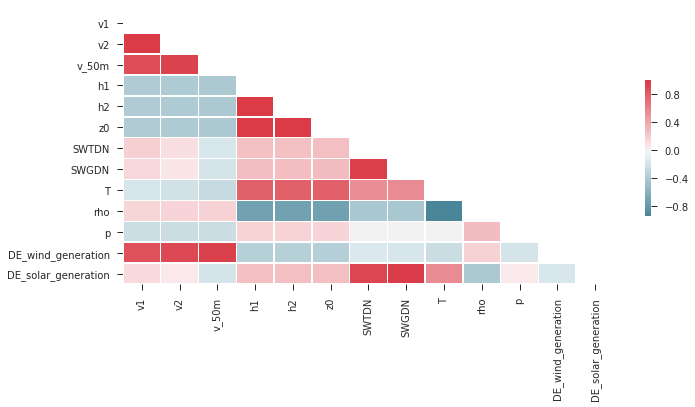

In [9]:
plot_correlation_matrix(df)

## Test setup

Running example:

In [10]:
train_s = df['DE_solar_generation'][(df.index >= '2016-01-01') & (df.index < '2016-02-01')]
test_s = df['DE_solar_generation'][(df.index >= '2016-02-01') & (df.index < '2016-02-02')]
p = figure(width=1500, height=250, x_axis_type='datetime', title='Solar')
p.line(x=train_s.index, y=train_s)
p.line(x=test_s.index, y=test_s, color='green')
show(p)

## Test setup

Running example:

In [11]:
train_w = df['DE_wind_generation'][(df.index >= '2016-01-01') & (df.index < '2016-02-01')]
test_w = df['DE_wind_generation'][(df.index >= '2016-02-01') & (df.index < '2016-02-02')]
p = figure(width=1500, height=250, x_axis_type='datetime', title='Wind')
p.line(x=train_w.index, y=train_w)
p.line(x=test_w.index, y=test_w, color='green')
show(p)

## Test setup - Metric

MSE,
RMSE,
MAE mean,
MdAE,
MAPE,
MdAPE,
sMAPE,
sMdAPE,
MRAE,
MdRAE,
GMRAE,
RelMAE,
RelRMSE,
LMR,
PB,
PB(MAE),
PB(MSE)

where M = Mean, Md = median, s = symmetric, P = Percentage, G = geometric, PB = percentage better etc.

## Test setup - Metric

Real values $x_t$ and predicition $\hat{x}_t$

$RMSE = \sqrt{\dfrac{1}{n}\sum\limits_{t=1}^n (\hat{x}_t - x_t)^2}$


In [12]:
import math
from sklearn.metrics import mean_squared_error

def calc_rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

## Commonly used forecast accuracy measures [reference here]


|$N$    (No seasonality)|$A$ (Additive)|$M$ (Multiplicative)| 
|---|:----:|:---:|
|MSE| Mean squared eror | mean$(e_t^2)$  |
|RMSE|  Root mean squared error|  $\sqrt{MSE}$ |
|MAE Mean| Absolute error  |mean$(|{e_t}|)$|
|MdAE|Mean absolute error|median$(|{e_t}|)$|

Also: MAPE, MdAPE, sMAPE, sMdAPE, MRAE, MdRAE, GMRAE, RelMAE, RelRMSE, LMR, PB, PB(MAE), PB(MSE),

- where M = Mean, Md = median, s = symmetric, P = Persentage, G = geometric, PB = percentage better etc.

## Approaches Overview

- Baselines
- Smoothing methods
- ARIMA
- Neural networks
    - MLP
    - RNN (LSTM...)

## Evaluation methodology

- How do we compare the different approaches?
- We split the data into train/test sets
    - 21 first days of each month to train
    - The rest to test
- We use MSE/RMSE between the forecast and the ground truth
- Separately for Wind and Solar energy generation

## Baseline 1 (naive approach)

Forecast last known value:

$\hat{x}_{T+h} = x_{T}$

## Baseline 1 (naive approach)

In [13]:
naive_baseline = pd.Series(test_w, copy=True)
naive_baseline[:] = train_w[-1]

## Baseline 1 (naive approach)

In [14]:
def visualize_results(train, test, prediction, title):
    p = figure(width=1500, height=250, x_axis_type='datetime', title=title)
    p.line(x=train.index, y=train)
    p.line(x=test.index, y=test, color='green')
    p.line(x=prediction.index, y=prediction, color='red')
    show(p)
    print('RMSE: {:.4f}'.format(calc_rmse(test, prediction)))

## Baseline 1 (naive approach)

In [15]:
visualize_results(train_w, test_w, naive_baseline, 'Baseline - last value')

RMSE: 12821.8534


<center>![baseline1evaluationsolar](img/Naive1_Solar.png)</center>

<center>![baseline1evaluationwind](img/Naive1_Wind.png)</center>

## Baseline 2 (periodic)

Replicate the last day when $p$ is the length of a day (period length).

$\hat{x}_{T+h}=x_{T-p+h}$

## Baseline 2 (periodic)


In [16]:
periodic_baseline = pd.Series(test_w, copy=True)
periodic_baseline[:] = train_w[-24:]

## Baseline 2 (periodic)


In [17]:
visualize_results(train_w, test_w, periodic_baseline, 'Baseline - periodic')

RMSE: 12678.9540


## Baseline 2 (periodic)


In [18]:
periodic_baseline = pd.Series(test_s, copy=True)
periodic_baseline[:] = train_s[-24:]

In [19]:
visualize_results(train_s, test_s, periodic_baseline, 'Baseline - periodic')

RMSE: 534.2467


<center>![baseline1evaluation](img/Naive2_Solar.png)</center>

<center>![baseline1evaluation](img/Naive2_Wind.png)</center>

## Baseline 3 (average)

Average of the last day when $p$ is the length of a day (period length).

$\hat{x}_{T+h}= \dfrac{1}{p} \sum\limits_{t=1}^p x_{T-p+t}$

## Baseline 3 (average)


In [20]:
avg_baseline = pd.Series(test_w, copy=True)
avg_baseline[:] = np.mean(train_w[-24:])

## Baseline 3 (average)


In [21]:
visualize_results(train_w, test_w, avg_baseline, 'Baseline - average')

RMSE: 9103.0593


## Baseline 3 (average)


In [22]:
avg_baseline = pd.Series(test_s, copy=True)
avg_baseline[:] = np.mean(train_s[-24:])

In [23]:
visualize_results(train_s, test_s, avg_baseline, 'Baseline - average')

RMSE: 990.9427


---

<center>![baseline3evaluation](img/Naive3_Solar.png)</center>

<center>![baseline3evaluation](img/Naive3_Wind.png)</center>

## Smoothing methods (SMA)

Simple moving average:

$\hat{x}_{T+1}=\dfrac{1}{n}\sum\limits_{t=T-n+1}^Tx_t$, 

 $n$ &mdash; "sliding window" size

## Smoothing methods (SMA)

To obtain a forecast of $\hat{x}_{T+h}$ we assume $x_{T+i}=\hat{x}_{T+i}, 0<i<h$

- if $n=p$, is SMA forecast $x_{T+h}$ equivalent to Baseline(3)?

- No

## Smoothing methods (SMA)

Assume $x={1,2,3,4}$, and $n=p=4$

Baseline: $x_5=x_6=2.5$

SMA: $\quad x_5=2.5$, $\quad x_6= \dfrac{2+3+4+2.5}{4} =2.875$

- suitable for series with no trend and seasonality (why?)
- for $n=1$ reduces to naive approach (baseline)

## Smoothing methods (SMA)

In [24]:
def calc_smoothing_average(train, test, n):
    smoothing_average = pd.Series(test, copy=True)
    T = len(train)
    for h in range(24):
        smoothing_average[h] = np.mean(train.append(smoothing_average)[T-n+h:T+h])
    return smoothing_average

## Smoothing methods (SMA)

In [25]:
smoothing_average = calc_smoothing_average(train_w, test_w, 5)
visualize_results(train_w, test_w, smoothing_average, 'Smoothing average n = 5')

RMSE: 12322.8514


## Smoothing methods (SMA)

In [26]:
smoothing_average = calc_smoothing_average(train_w, test_w, 24)
visualize_results(train_w, test_w, smoothing_average, 'Smoothing average n = 24')

RMSE: 10507.3629


## Smoothing methods (SMA)

- choice of optimal $n$: (optimization procedure description)(look in the web and book)
- excercise: what happens when there is a clear upward/downward trend in the data and $AC(1)>0$? Here 
$ AC(1)=\frac{\sum_{t=1}^{T-1}(x_t-\bar{x})(x_{t+1}-\bar{x})}{\sum_{t=1}^T (x_t-\bar{x})^2}$ and $\bar x = \sum_{t=1}^T (x_t)/T$
- python example (e.g. just apply SMA(1) and SMA(10) to periodic series measuring forecasting quality and showing one of the forecxasts)

## Smoothing methods (WMA)

Weighted moving average

$\hat{x}_{T+1}=\sum\limits_{t=T-n+1}^Tw_{t}\cdot x_t\qquad$ with $\sum\limits_{t=1}^nw_{t}=1$



- reduces to moving average when $w_i=1/n$
- reduces to naive approach when $n=1$

## Smoothing methods (WMA)

In [27]:
def calc_weighted_average(train, test, n, weights):
    weighted_average = pd.Series(test, copy=True)
    T = len(train)
    for h in range(24):
        weighted_average[h] = np.sum(weights * train.append(weighted_average)[T-n+h:T+h])
    return weighted_average

## Smoothing methods (WMA)

In [28]:
weighted_average = calc_weighted_average(train_w, test_w, 3, [1/6, 1/3, 1/2])
visualize_results(train_w, test_w, weighted_average, 'Weighted average n = 3')

RMSE: 12623.4852


## Smoothing methods (SES)

Simple exponential smoothing

$\hat{x}_{T+1}=\sum\limits_{t=T-n+1}^Tw_{t}\cdot x_t$,

$w_i=\alpha(1-\alpha)^i$


recursive formula: 
$\quad \hat{x}_{T+1}=\alpha\, x_T + (1-\alpha)\,\hat{x}_T$

## Smoothing methods (SES)


In [29]:
def calc_weights_exponential_smoothing(alpha, n):
    return [alpha * (1 - alpha)**i for i in range(n)]

In [30]:
n = 5
p = figure(width=1500, height=250)
for alpha, color in zip([0.25, 0.5, 0.75, 0.9], palette[4]):
    p.line(x=range(n), y=calc_weights_exponential_smoothing(alpha, n), legend='{}'.format(alpha), color=color)
show(p)

In [31]:
df_ses_solar = pd.read_csv('../data/DE_solar_generation_exp.csv')
df_ses_wind = pd.read_csv('../data/DE_wind_generation_exp.csv')
df_ses_solar.head()

ANN           AAN       ANA       AAA
0  8.032112e-28  4.382131e-10 -6.191154 -9.077965
1  8.032112e-28  7.890688e-10 -2.124731  0.927916
2  8.032112e-28  1.072667e-09 -0.124650  1.032589
3  8.032112e-28  1.301902e-09 -1.931459  0.794272
4  8.032112e-28  1.487193e-09  0.661227  1.933498

In [32]:
def visualize_ses(t, d):
    if t == 'wind':
        s = pd.Series(test_w, copy=True)
        s[:] = df_ses_wind[d].values
        visualize_results(train_w, test_w, s, d)
    elif t == 'solar':
        s = pd.Series(test_w, copy=True)
        s[:] = df_ses_solar[d].values
        visualize_results(train_s, test_s, s, d)

## Smoothing methods (SES)

recursive formula: 

$\hat{x}_{T+1}=\alpha x_T + (1-\alpha)\hat{x}_T$ 

or $\hat{x}_{T+1}=\alpha e_T + \hat{x}_T$, $e_T=x_T-\hat{x}_T$

- $\hat{x}_{T+h}=\hat{x}_{T+1}$ (why?)

## Smoothing methods (SES)

Estimating $\alpha$ (for one step ahead forecast)
- set a grid of $\alpha$ values, e.g. $\,\alpha=\{0.1,0.2,...,0.9\}$

- for each $\alpha$

$\hat{x}_2=x_1$, 
$\quad e_2=x_2-\hat{x}_2$
$\quad$...
$\quad e_T=x_T-\hat{x}_T$

- choose $\alpha$ providing minimum value of $\sum\limits_{i=2}^T e_i^2$   

## Smoothing methods (SES)


In [33]:
visualize_ses('wind', 'ANN')

RMSE: 12821.8168


## Smoothing methods (SES)


In [34]:
visualize_ses('solar', 'ANN')

RMSE: 1146.6891


<center>![SimpleExpSmoothSolar](img/ExpSmoothANN_Solar.png)</center>

<center>![SimpleExpSmooth](img/ExpSmoothANN_Wind.png)</center>

## Smoothing methods (double exponential smoothing)

we redefine 

$\hat{x}_{T+1}=l_T$, 

$l$ &mdash; "level" of the series

then the SES equation is: 

$l_t=\alpha \,x_t+(1-\alpha)\,l_{t-1}$

## Smoothing methods (double exponential smoothing)

Exponential smoothing with trend ($b$):

$l_t=\alpha\, x_t+(1-\alpha)\,(l_{t-1}+b_{t-1})$

$b_t=\beta\,(l_t-l_{t-1})+(1-\beta)\,b_{t-1}$

Forecast:

$\hat{x}_{T+h}=l_T+h \,b_T$

## Smoothing methods (DES, damped trend)

Exponential smoothing with dumped trend (just appears a new parameter $\phi$):

$l_t=\alpha x_t+(1-\alpha)(l_{t-1}+\phi b_{t-1})$

$b_t=\beta(l_t-l_{t-1})+(1-\beta)\phi b_{t-1}$

Forecast:

$\hat{x}_{T+h}=l_T+(\phi+\phi^2+...+\phi^h)b_T$

## Smoothing methods (double exponential smoothing)


In [35]:
visualize_ses('wind', 'AAN')

RMSE: 14292.3857


## Smoothing methods (double exponential smoothing)


In [36]:
visualize_ses('solar', 'AAN')

RMSE: 1146.6891


<center>![DoubleExpSmooth](img/ExpSmoothAAN_Solar.png)</center>

<center>![DoubleExpSmooth](img/ExpSmoothAAN_Wind.png)</center>

## Smoothing methods (triple exponential smoothing)

Exponential smoothing with trend ($b$) and seasonality ($s$):

$l_t=\alpha (x_t-s_{t-p})+(1-\alpha)(l_{t-1}+b_{t-1})$

$b_t=\beta(l_t-l_{t-1})+(1-\beta)b_{t-1}$

$s_t=\gamma(x_t-l_{t-1}-b_{t-1})+(1-\gamma)s_{t-p}$, 

where $p$ is the length of the period

## Smoothing methods (triple exponential smoothing)

Forecast:

$\hat{x}_{T+h}=l_T+hb_T+s_{t-p+h}$

## Smoothing methods (triple exponential smoothing)


In [37]:
visualize_ses('wind', 'AAA')

RMSE: 13599.3541


## Smoothing methods (triple exponential smoothing)


In [38]:
visualize_ses('solar', 'AAA')

RMSE: 609.7052


<center>![TripleExpSmooth](img/ExpSmoothAAA_Solar.png)</center>

<center>![TripleExpSmooth](img/ExpSmoothAAA_Wind.png)</center>

## Taxonomy of exponential smoothing methods


||$N$    (No seasonality)|$A$ (Additive)|$M$ (Multiplicative)| 
|---|:----:|:---:|:---:|
|$N$ (No trend)| $(N,N)$ | $(N,A)$  |$(N,M)$|
|$A$ (Additive)|  $(A,N)$|  $(A,A)$ |$(A,M)$|
|$A_d$ (Dumped additive)| $(A_d, N)$  | $(A_d, A)$  |$(A_d, M)$ |
|$M$ (Multiplicative)|$(M,N)$|$(M,A)$|$(M,M)$|
|$M_d$ (Dumped multiplicative)|$(M_d, N)$|$(M_d, A)$|$(M_d, M)$|

---

## ARIMA model: preliminaries

Autocorrelation coefficient for lag $k$:

$r_k=cor(x_t, x_{t-k})$

Autocorrelation function (ACF):

$f(k)=r_k$

## ARIMA model: preliminaries

White noise &mdash; series with no autocorrelation: 

$r_k=0, \forall k$

## ARIMA model: preliminaries

Partial autocorrelation coefficient/function (PACF):

relationship between $x_t$ and $x_{t-k}$ after removing the effects of $x_{t-1}, ..., x_{t-k+1}$

- the value of $\phi_k$ in the model $x_t = c + \phi_1x_{t-1} + ... + \phi_k x_{t-k}+e_t$

## ARIMA model: AR and MA

autoregressive process $AR(p)$:

$x_t = c + \phi_1x_{t-1} + ... + \phi_p x_{t-p}+e_t$

Moving average process $MA(q)$:

$x_t = c + \theta_1e_{t-1} + ... + \theta_q e_{t-q}+e_t$

## ARIMA model: AR and MA

- under some restrictions the following holds: $AR(p)=MA(\infty)$ and $MA(q)=AR(\infty)$

## ARIMA:  AR and MA

Explanation

In [39]:
ts1 = pd.read_csv('../data/arima_ts1', header=None)[0].values

## ARIMA: AR(2)

In [40]:
p = figure(width=1500, height=250)
p.line(x=range(len(ts1)), y=ts1)
show(p)

## ARIMA: AR(2)

In [41]:
def plot_acf_pacf(series, lags=30):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    _ = plot_acf(series, ax=ax1, lags=lags, zero=False)
    _ = plot_pacf(series, ax=ax2, lags=lags, zero=False)

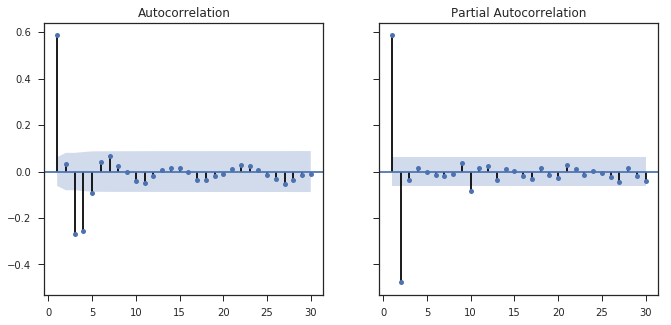

In [42]:
plot_acf_pacf(ts1)

## ARIMA: MA(2)

In [43]:
ts2 = pd.read_csv('../data/arima_ts2', header=None)[0].values

In [44]:
p = figure(width=1500, height=250)
p.line(x=range(len(ts2)), y=ts2)
show(p)

## ARIMA: MA(2)

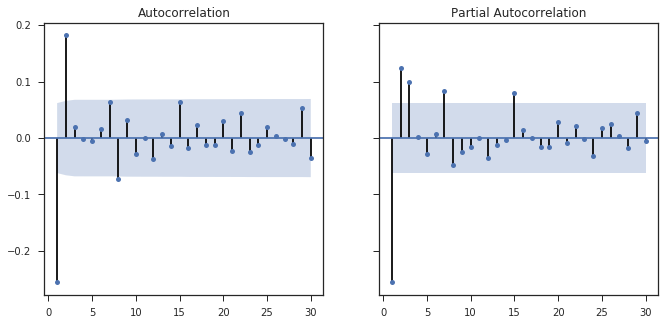

In [45]:
plot_acf_pacf(ts2)

## ARIMA model: stationarity

the properties of stationary time series do not depend on the observation time

- the distribution $p(x_t,...,x_{t+k})$ does not depend on t

Differencing:

$x_t'=x_t-x_{t-1}$, $x_t''=x_t'-x_{t-1}'$,...

- usually helps to make the series stationary

## ARIMA model: stationarity

statistical tests for stationarity:

- Augmented Dickey-Fuller (ADF) test (expect small p-value)
- Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test (expect large p-value)

Note: not used for testing seasonal stationarity!

In [46]:
from statsmodels.tsa.stattools import adfuller, kpss

def run_stats_tests(series):
    return 'KPSS: {:.4f}  ADF: {:.4f}'.format(kpss(series)[1], adfuller(series)[1])

## ARIMA model

$x_t'=c+\phi_1x_{t-1}'+...+\phi_p x_{t-p}'+\theta_1e_{t-1}+...+\theta_q e_{t-q}+e_t$

- $p$ &mdash; order of AR part
- $d$ &mdash; order of differencing
- $q$ &mdash; order of MA part

coefficients $\phi_i$ and $\theta_j$ are selected e.g. by minimizing sum of squared residuals

## ARIMA model: fitting process

- plot data, identify patterns and exclude outliers (unusial observations)
- choose $d$ parameter using stationary tests
- Plot ACF/PACF, try to define parameters $p$ and $q$ (select several sets)
- Try chosen models, choose the one with better prediction quality (criterion AICc)
- Check residuals with plotting ACF/PACF of residuals and performing test for white noise
- If the residuals are not looking as white noise, try different models

## ARIMA model: fitting process

- Or just use some automated version of ARIMA

Warning: automated versions usually not performing the last two steps

## ARIMA Example

In [47]:
train_p = df['p'][(df.index >= '2016-01-01') & (df.index < '2016-02-01')]
test_p = df['p'][(df.index >= '2016-02-01') & (df.index < '2016-02-02')]
p = figure(width=1500, height=250, x_axis_type='datetime')
p.line(x=train_p.index, y=train_p)
p.line(x=test_p.index, y=test_p, color='red')
show(p)
print(run_stats_tests(train_p))

KPSS: 0.0100  ADF: 0.2421


## ARIMA Example

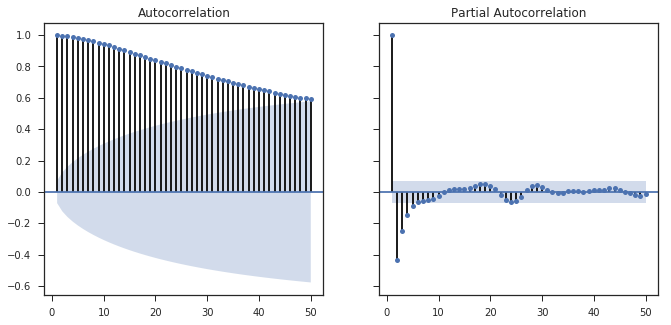

In [48]:
plot_acf_pacf(train_p, lags=50)

## ARIMA Example

Normal:       KPSS: 0.0100  ADF: 0.2421
Differences:  KPSS: 0.1000  ADF: 0.0148


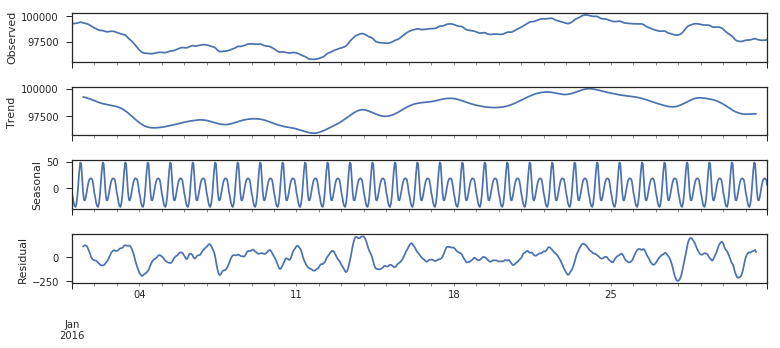

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
_ = seasonal_decompose(train_p).plot()
print('Normal:      ', run_stats_tests(train_p))
print('Differences: ', run_stats_tests(train_p.diff()[1:]))

## ARIMA Example

Differenced series

In [50]:
train_p_diff = train_p.diff(1)
test_p_diff = test_p.diff(1)
p = figure(width=1500, height=250, x_axis_type='datetime')
p.line(x=train_p_diff.index, y=train_p_diff)
p.line(x=test_p_diff.index, y=test_p_diff, color='red')
show(p)
print(run_stats_tests(train_p))

KPSS: 0.0100  ADF: 0.2421


## ARIMA Example

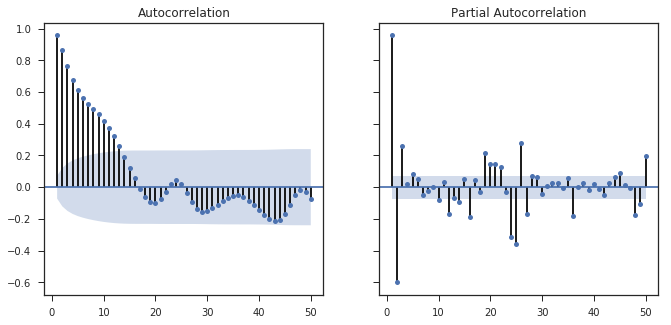

In [51]:
plot_acf_pacf(train_p_diff[1:], lags=50)

## ARIMA Example

In [52]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_p, (3, 1, 0)).fit()
show(Line(model.resid, legend=False, plot_width=1500, plot_height=250))

E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='18e42675-35e6-42e3-b1d5-f7444e694ed0', ...)


## ARIMA Example

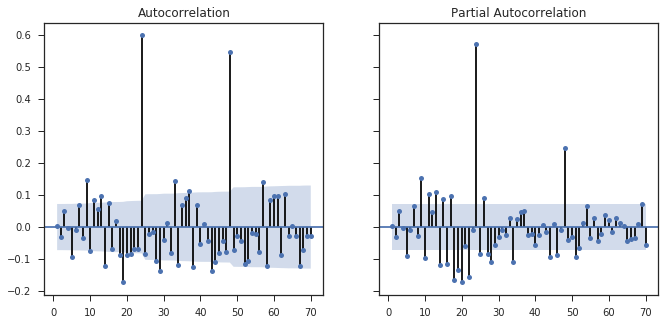

In [53]:
plot_acf_pacf(model.resid, lags=70)

## ARIMA Example

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(train_p, order=(3, 1, 0), seasonal_order=(1, 0, 1, 24)).fit()
show(Line(sarima.resid[2:], legend=False, plot_width=1500, plot_height=250))

E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='79ee4d23-ee2a-4ed1-b54d-9461dfc732e1', ...)


## ARIMA Example

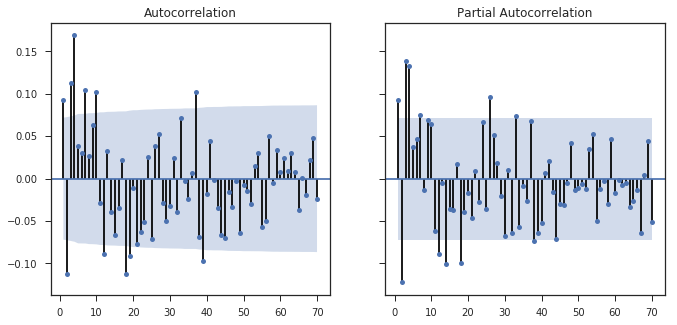

In [55]:
plot_acf_pacf(sarima.resid[2:], lags=70)

## ARIMA Example

In [56]:
sarima2 = SARIMAX(train_p, order=(3, 1, 2), seasonal_order=(1, 0, 1, 24), enforce_invertibility=False, enforce_stationarity=False).fit()

In [57]:
sarima2_residual = pd.read_csv('../data/residual_sarima2', header=None).values.flatten()

In [58]:
show(Line(sarima2_residual, legend=False, plot_width=1500, plot_height=250))

E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='377a2686-acea-4e3a-be9d-98d611ef8fec', ...)


## ARIMA Example

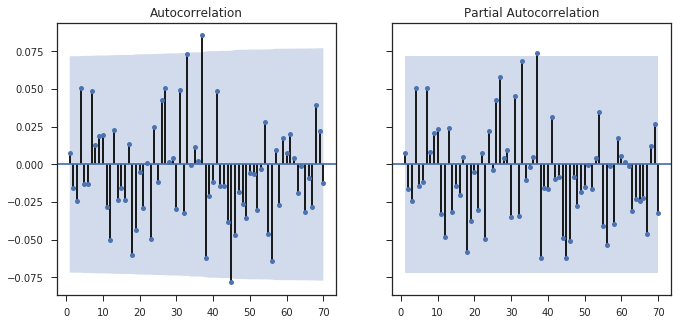

In [59]:
plot_acf_pacf(sarima2_residual, lags=70)

## ARIMA

Random walk test on residuals

In [60]:
from statsmodels.stats.diagnostic import acorr_ljungbox
print('Original: ', acorr_ljungbox(sarima.resid[2:], lags=48)[1][-1])
print('Final:    ', acorr_ljungbox(sarima2_residual, lags=48)[1][-1])

Original:  4.20941879872e-13
Final:     0.477041983767


<center>![ARIMAsolar](img/ARIMA_Solar.png)</center>

<center>![ARIMAwind](img/ARIMA_Wind.png)</center>

---

# Artificial Neural Networks (ANNs)

- *Connectionist* approach
- Loosely inspired from biology
- Currently "hype", thanks to *Deep Learning*
    - Speech recognition
    - Image recognition
    - Machine translation

# Perceptron

![artificialneuron](img/neuron.png)

$y = \varphi  \left (\sum x_{i}*w_{i} \right )$

# Activation Functions

![activation](img/activation.png)

# Learning Rule

- via Gradient Descent

$w_{ij} = w_{ij} - \eta \frac{\delta E}{\delta w_{ij}} $

$\eta$ : Learning rate

$E$: Loss function, e.g. MSE $E = \frac{1}{2} \sum{(t_{i} - y_{i})^2}$

$\frac{\delta E}{\delta w_{ij}}$: Derivative of $E$ w.r.t. $w_{ij}$





# Multi-Layer-Perceptron

<center>![baseline1evaluationsolar](img/MLP_1.png)</center>

<center> ![artificialneuron](img/MLP_2.png) </center>


# Pros

- Can achieve very good accuracy
- Many efficient frameworks/implementations exist

# Cons

- Convergence to global optimum is not garanteed
- Training is slow
- Requires a lot of training data

# Forecasting using ANNs

- Basic idea:
    - Forecast the next day of solar energy production
    - Based on the current day

In [61]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from bokeh.plotting import figure, show, output_notebook, gridplot
from bokeh.charts import Line
from sklearn.metrics import mean_squared_error

output_notebook()
sns.set(style="ticks")
plt.rcParams['figure.figsize'] = (11, 3)
np.random.seed(1)

Using TensorFlow backend.


Loading BokehJS ...

In [62]:
df = pd.read_csv('../data/weather_and_power_generation.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [63]:
# Data wrangling functions
def extract_data(df, daycutoff=21):
    train = df[feature][df.index.day <= daycutoff]
    test = df[feature][df.index.day > daycutoff]
    return train, test

def create_dataset(dataset, days_look_back=1, stepsize=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-days_look_back*24-24, stepsize):
        a = dataset[i:(i+days_look_back*24)]
        dataX.append(a)
        b =  dataset[i+24:(i+24+days_look_back*24)]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def create_prediction_data(df, daycutoff=21, 
                        days_look_back=1, stepsize=1):
    train, test = extract_data(df, daycutoff)
    train_x, train_y = create_dataset(train, days_look_back, stepsize = stepsize)
    test_x, test_y = create_dataset(pd.concat([train, test])[-len(test)-days_look_back*24-1:], 
                                    days_look_back, stepsize = stepsize)
    
    return ((train_x, train_y), (test_x, test_y))

In [64]:
# Model-related functions
def fit_model(model, df, days_look_back=1, nepoch=10, model_type='standard', stepsize=1):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = stepsize)
    if model_type == 'lstm':
        train_x, test_x = transform_for_lstm(train_x, test_x)
    model.fit(train_x, train_y, epochs=nepoch, batch_size=1, verbose=1, validation_data=(test_x, test_y))
    return model

def score_model(model, visualize_full=False, visualize_pred=True, days_look_back=1, stepsize=1):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = stepsize)
    score = test_model(model, train_x, train_y, test_x, test_y)
    
    # For visualization take only full days 
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = 24)
    if visualize_full:
        plot_full(model, train_x, train_y, test_x, test_y)
    if visualize_pred:
        plot_prediction(model, test_x, test_y)
        
    plot_last_days(model, test_x, test_y)
    return score

def test_model(model, train_x, train_y, test_x, test_y):
    train_score = model.evaluate(train_x, train_y, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
    test_score = model.evaluate(test_x, test_y, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))
    return test_score

In [65]:
# Plotting functions
def plot_full(model, train_x, train_y, test_x, test_y):
    full_y = np.concatenate([train_y, test_y])
    labels_test = range(len(train_y), len(full_y))
    plt.plot(full_y)
    plt.plot(model.predict(train_x))
    plt.plot(labels_test, test_y)
    plt.plot(labels_test, model.predict(test_x))

def plot_prediction(model, test_x, test_y):
    d = pd.DataFrame(data=[test_y.flatten(), model.predict(test_x).flatten()]).T
    d.columns = ["actual", "predicted"]
    chart = Line(d, legend=True, plot_width=900, plot_height=300)
    show(chart)
    
def plot_last_days(model, test_x, test_y):    
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aou", "Sep", "Oct", "Nov", "Dec"]
    prediction = model.predict(test_x)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11,9), sharey=True, sharex=True)

    for i,x in enumerate([9,18,28,37,47,56,66,76,85,95,104,113]):
        ax = pd.Series(prediction[x]).plot(ax=axes[math.floor(i/4), i%4], color="Green")
        pd.Series(test_y[x][0:24]).plot(ax=ax, color="Red")
        
        ax.title.set_text(months[i])

# First Attempt

- Train on one day, forecast the next day of solar generation
- Use the 21st first days of each month for training, keep the rest for validation

## Simple architecture

- 24 input neurons
- 10 hidden neurons
- 24 output neurons

In [66]:
stepsize = 24 # train on full day
feature='DE_solar_generation' # solar generation

model = Sequential()
model.add(Dense(10, input_dim=24, activation='relu'))       # 24 neurons input
model.add(Dense(10, input_dim=10, activation='relu'))       # 10 hidden neurons, 1 layer
model.add(Dense(24))                                        # 24 neurons output
model.compile(loss='mean_squared_error', optimizer='adam')

In [67]:
model = fit_model(model, df, nepoch=1, stepsize = stepsize)

Train on 250 samples, validate on 114 samples
Epoch 1/1
250/250 [==============================] - 0s - loss: 28029273.4473 - val_loss: 8698526.5019


Train Score: 5587411.94 MSE (2363.77 RMSE)
Test Score: 8698526.54 MSE (2949.33 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='2f6d84f1-0eb5-4614-b79a-11ceb882c8d6', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='3f809f33-d5ee-41c9-9a57-a2a1bec88bae', ...)


8698526.5394736845

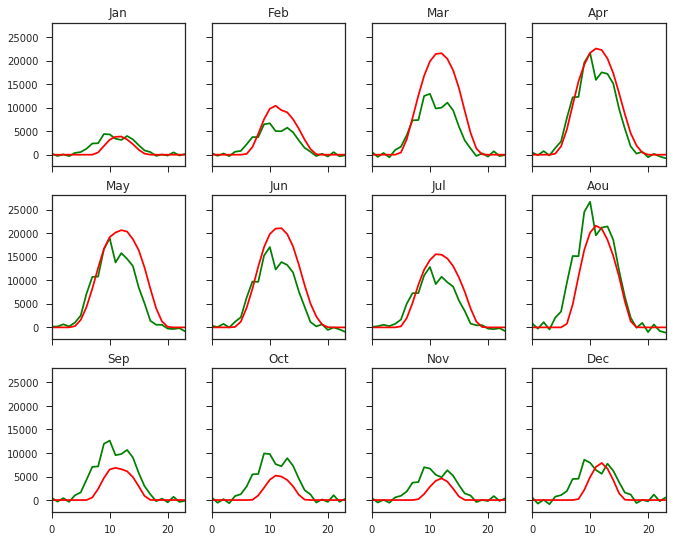

In [68]:
score_model(model, stepsize = stepsize) 

In [69]:
model = fit_model(model, df, nepoch=9, stepsize = stepsize)

Train on 250 samples, validate on 114 samples
Epoch 1/9
250/250 [==============================] - 0s - loss: 5084381.8775 - val_loss: 7961986.4995
Epoch 2/9
250/250 [==============================] - 0s - loss: 4911568.1945 - val_loss: 8867985.4507
Epoch 3/9
250/250 [==============================] - 0s - loss: 5081147.1417 - val_loss: 7891785.1253
Epoch 4/9
250/250 [==============================] - 0s - loss: 4903327.8109 - val_loss: 8492055.0669
Epoch 5/9
250/250 [==============================] - 0s - loss: 5006271.7207 - val_loss: 8477432.1198
Epoch 6/9
250/250 [==============================] - 0s - loss: 4783197.8033 - val_loss: 8376945.0414
Epoch 7/9
250/250 [==============================] - 0s - loss: 4805235.9914 - val_loss: 8554498.0137
Epoch 8/9
250/250 [==============================] - 0s - loss: 4888891.2914 - val_loss: 8627003.3662
Epoch 9/9
250/250 [==============================] - 0s - loss: 4680612.8515 - val_loss: 8413945.7626


Train Score: 4619471.62 MSE (2149.30 RMSE)
Test Score: 8413945.47 MSE (2900.68 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='4ddb735f-b7d0-474a-ab87-2c7ed147a265', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='db0357a2-51ca-4a3a-a3aa-2864e8e9e8dd', ...)


8413945.4736842103

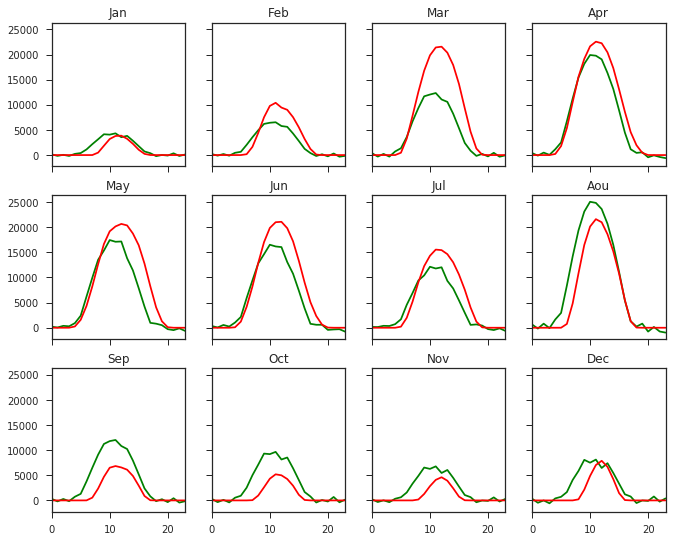

In [70]:
score_model(model, stepsize = stepsize)

## Problem

- Not enough data => Overfitting

- Solution: train on a sliding window instead
    - 250 -> 6000 training examples

In [71]:
model = fit_model(model, df, nepoch=1, stepsize = 1)

Train on 6000 samples, validate on 2713 samples
Epoch 1/1
6000/6000 [==============================] - 7s - loss: 7050915.9115 - val_loss: 4757985.9626


Train Score: 4025777.64 MSE (2006.43 RMSE)
Test Score: 4093565.05 MSE (2023.26 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='c7e0bedc-de7a-4344-9b57-77f6e15191b8', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='e3fe07a7-801b-49b9-b6a8-0baef2022eae', ...)


4093565.0493918173

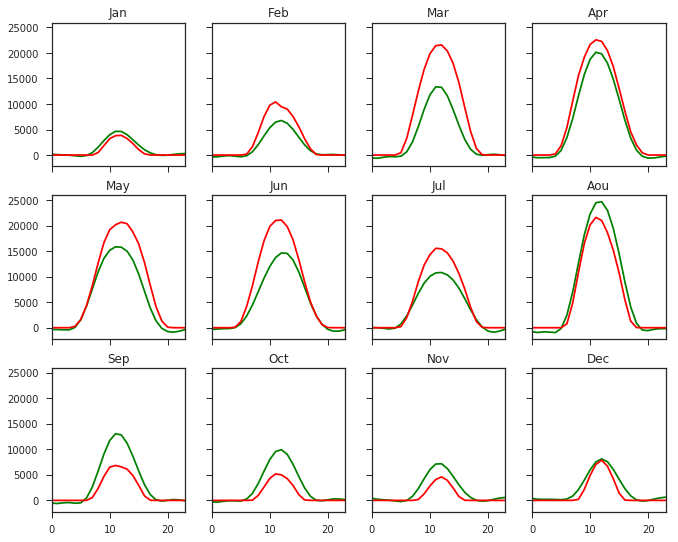

In [72]:
model = load_model("model_solar_50_checkpoint")
score_model(model, stepsize = 1)

# Let's try the same for wind

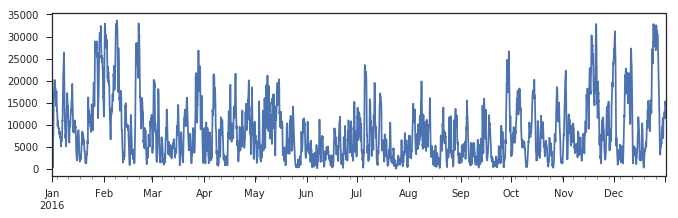

In [73]:
feature='DE_wind_generation' # this acts as a global variable
df[feature].plot()

In [74]:
model = Sequential()
model.add(Dense(10, input_dim=24, activation='relu'))
model.add(Dense(10, input_dim=10, activation='relu'))
model.add(Dense(24))
model.compile(loss='mean_squared_error', optimizer='adam')

In [75]:
model = fit_model(model, df, days_look_back=1, nepoch=1)

Train on 6000 samples, validate on 2713 samples
Epoch 1/1
6000/6000 [==============================] - 8s - loss: 28555927.3127 - val_loss: 23298007.1423


Train Score: 19457290.98 MSE (4411.04 RMSE)
Test Score: 21384283.81 MSE (4624.31 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='960dd356-bca9-44d5-b0b6-e615c789953d', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='abb7bde8-a306-436c-af22-910f872a5e6f', ...)


21384283.814596388

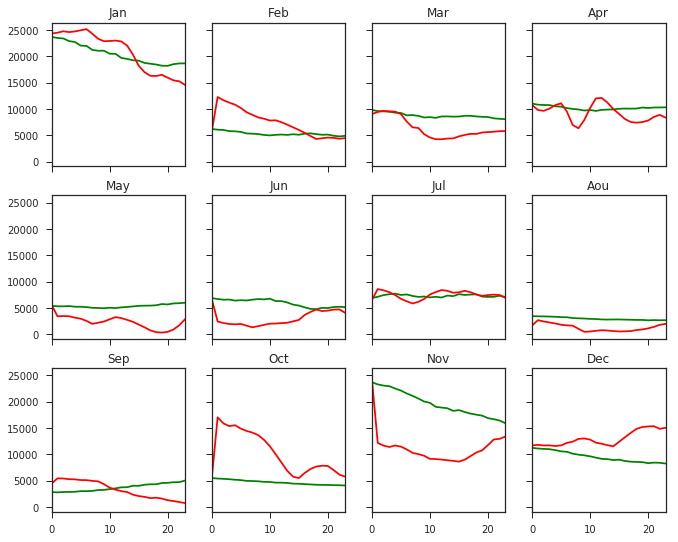

In [76]:
model = load_model("model_wind_50_checkpoint")
score_model(model)

# This is not very good

- Let's assume we have a good forecast for tomorrow
- We feed this forecast to the neural network, as additional information 
- We increase the size of the network
    - 94 input neurons
    - 2 * 50 hidden neurons
    - 24 output neurons

In [77]:
# Small modifications in this function
def create_dataset(dataset, days_look_back=1, stepsize=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-days_look_back*24-24, stepsize):
        a1 = np.array(dataset[i:(i+days_look_back*24)][target])
        a2 = np.array(dataset[i+24:(i+24+days_look_back*24)][forecast]).T.flatten()
        
        dataX.append(np.concatenate([a1,a2]))
        b =  dataset[i+24:(i+24+days_look_back*24)][target]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

# Solar

In [78]:
forecast = ['T', 'SWTDN', 'SWGDN']
target = 'DE_solar_generation'
feature = forecast + [target]

In [79]:
model = Sequential()
model.add(Dense(50, input_dim=96, activation='relu'))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(24))
model.compile(loss='mean_squared_error', optimizer='adam') 

In [80]:
model = fit_model(model, df, nepoch=1)

Train on 6000 samples, validate on 2713 samples
Epoch 1/1
6000/6000 [==============================] - 9s - loss: 4733794.1608 - val_loss: 3338789.6267


Train Score: 1093986.57 MSE (1045.94 RMSE)
Test Score: 1425301.48 MSE (1193.86 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='11272a64-e4a7-46e0-b6c9-e60d8499c6c6', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='5ee3736f-d975-4b6f-927e-9795e3466aef', ...)


1425301.4826875231

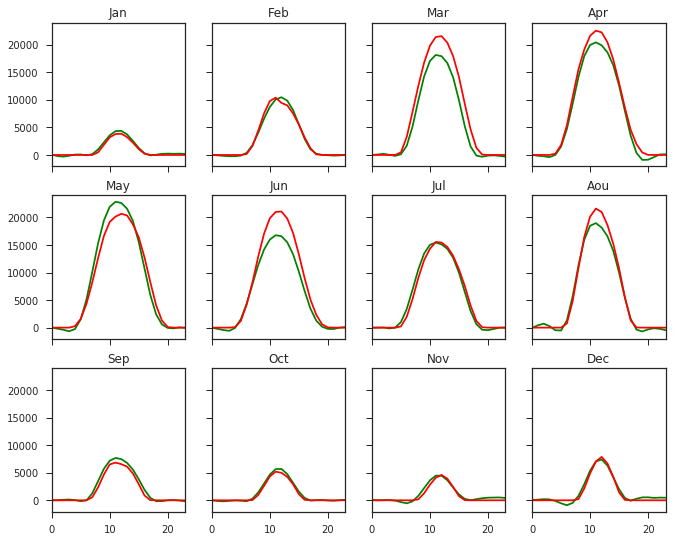

In [81]:
model = load_model("model_solar_extended_50_checkpoint")
score_model(model) 

# Wind

In [82]:
forecast = ['v1', 'v2', 'v_50m']
target = 'DE_wind_generation'
feature = forecast + [target]

In [83]:
model = Sequential()
model.add(Dense(50, input_dim=96, activation='relu'))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(50, input_dim=50, activation='relu'))
model.add(Dense(24))
model.compile(loss='mean_squared_error', optimizer='adam') 

In [84]:
model = fit_model(model, df, nepoch=1)

Train on 6000 samples, validate on 2713 samples
Epoch 1/1
6000/6000 [==============================] - 9s - loss: 24727171.4535 - val_loss: 27734378.4795


Train Score: 8923851.39 MSE (2987.28 RMSE)
Test Score: 10849296.17 MSE (3293.83 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='565afae8-11a8-469d-8936-380f0964c278', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='cf6a6f7e-29e2-4ff8-a221-fb231457093f', ...)


10849296.165775893

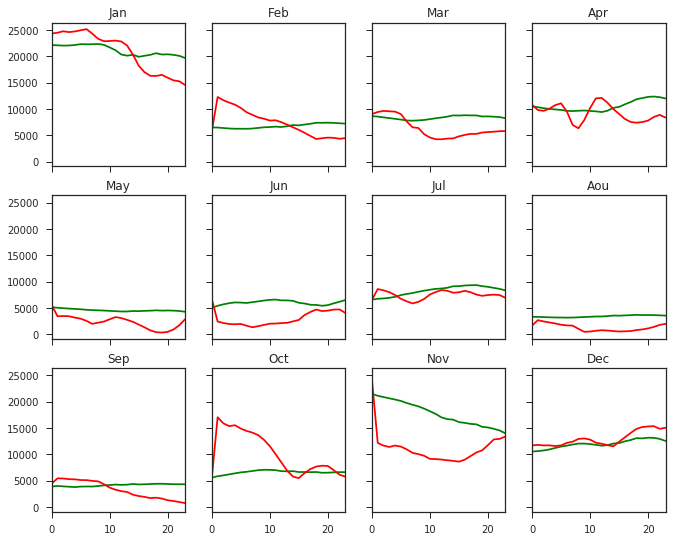

In [85]:
model = load_model("model_wind_extended_50_checkpoint")
score_model(model)

---

# MULTIVARIATE

In [86]:
def extract_data(df, daycutoff=21):
    train = df[feature][df.index.day <= daycutoff]
    test = df[feature][df.index.day > daycutoff]
    return train, test

# convert an array of values into a dataset matrix
def create_dataset(dataset, days_look_back=1, stepsize=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-days_look_back*24-24, stepsize):
        a = dataset[i:(i+days_look_back*24)]
        dataX.append(a)
        b =  dataset[i+24:(i+24+days_look_back*24)]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def create_prediction_data(df, daycutoff=21, 
                        days_look_back=1, stepsize=1):
    train, test = extract_data(df, daycutoff)
    train_x, train_y = create_dataset(train, days_look_back, stepsize = stepsize)
    test_x, test_y = create_dataset(pd.concat([train, test])[-len(test)-days_look_back*24-1:], 
                                    days_look_back, stepsize = stepsize)
    
    return ((train_x, train_y), (test_x, test_y))

def transform_for_lstm(train_x, test_x):
    train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))
    return train_x, test_x

In [87]:
def test_model(model, train_x, train_y, test_x, test_y):
    train_score = model.evaluate(train_x, train_y, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
    test_score = model.evaluate(test_x, test_y, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))
    return test_score

def plot_full(model, train_x, train_y, test_x, test_y):
    full_y = np.concatenate([train_y, test_y])
    labels_test = range(len(train_y), len(full_y))
    plt.plot(full_y)
    plt.plot(model.predict(train_x))
    plt.plot(labels_test, test_y)
    plt.plot(labels_test, model.predict(test_x))

def plot_prediction(model, test_x, test_y):
    #plt.plot(test_y)
    #plt.plot(model.predict(test_x))
    d = pd.DataFrame(data=[test_y.flatten(), model.predict(test_x).flatten()]).T
    d.columns = ["actual", "predicted"]
    chart = Line(d, legend=True, plot_width=900, plot_height=300)
    show(chart)
    
def plot_last_days(model, test_x, test_y):    
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aou", "Sep", "Oct", "Nov", "Dec"]
    prediction = model.predict(test_x)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11,9), sharey=True, sharex=True)

    for i,x in enumerate([9,18,28,37,47,56,66,76,85,95,104,113]):
        ax = pd.Series(prediction[x]).plot(ax=axes[math.floor(i/4), i%4], color="Green")
        pd.Series(test_y[x][0:24]).plot(ax=ax, color="Red")
        
        ax.title.set_text(months[i])

def fit_model(model, df, days_look_back=1, nepoch=10, model_type='standard', stepsize=1):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = stepsize)
    if model_type == 'lstm':
        train_x, test_x = transform_for_lstm(train_x, test_x)
    model.fit(train_x, train_y, epochs=nepoch, batch_size=1, verbose=1, validation_data=(test_x, test_y))
    return model

def score_model(model, visualize_full=False, visualize_pred=True, visualize_days=True, days_look_back=1, stepsize=1):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = stepsize)
    score = test_model(model, train_x, train_y, test_x, test_y)
    
    # For visualization take only full days 
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = 24)
    if visualize_full:
        plot_full(model, train_x, train_y, test_x, test_y)
    if visualize_pred:
        plot_prediction(model, test_x, test_y)
    if visualize_days:
        plot_last_days(model, test_x, test_y)
    return score

In [88]:
def create_dataset(dataset, days_look_back=1, stepsize=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-days_look_back*24-24, stepsize):
        a1 = np.array(dataset[i:(i+days_look_back*24)][target]).T.flatten()
        a2 = np.array(dataset[i+24:(i+24+days_look_back*24)][forecast]).T.flatten()
        
        dataX.append(np.concatenate([a1,a2]))
        b =  np.array(dataset[i+24:(i+24+days_look_back*24)][target]).T.flatten()
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def plot_prediction(model, test_x, test_y, title=['Solar', 'Wind']):
    prediction = model.predict(test_x)
    d1 = pd.DataFrame(data=[np.array([x[0:24] for x in test_y]).flatten(),
                            np.array([x[0:24] for x in prediction]).flatten()]).T
    d1.columns = ["actual", "predicted"]
    chart1 = Line(d1, legend=True, plot_width=900, plot_height=300, title=title[0])
    d2 = pd.DataFrame(data=[np.array([x[24:48] for x in test_y]).flatten(),
                            np.array([x[24:48] for x in prediction]).flatten()]).T
    d2.columns = ["actual", "predicted"]
    chart2 = Line(d2, legend=True, plot_width=900, plot_height=300, title=title[1])
    show(gridplot([chart1, chart2], ncols=1))

def plot_last_days(model, test_x, test_y):    
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aou", "Sep", "Oct", "Nov", "Dec"]
    prediction = model.predict(test_x)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11,9), sharey=True, sharex=True)

    for i,x in enumerate([9,18,28,37,47,56,66,76,85,95,104,113]):
        ax = pd.Series(prediction[x][0:24]).plot(ax=axes[math.floor(i/4), i%4], color="Green")
        pd.Series(test_y[x][0:24]).plot(ax=ax, color="Red")
        ax = pd.Series(prediction[x][24:48]).plot(ax=axes[math.floor(i/4), i%4], color="Blue")
        pd.Series(test_y[x][24:48]).plot(ax=ax, color="Orange")
        
        ax.title.set_text(months[i])
        
def score_split(model):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=1, stepsize = 1)
    prediction = model.predict(test_x)
    d1 = pd.DataFrame(data=[np.array([x[0:24] for x in test_y]).flatten(),
                            np.array([x[0:24] for x in prediction]).flatten()]).T
    d1.columns = ["actual", "predicted"]
    d2 = pd.DataFrame(data=[np.array([x[24:48] for x in test_y]).flatten(),
                            np.array([x[24:48] for x in prediction]).flatten()]).T
    d2.columns = ["actual", "predicted"]
    d1_RMSE = math.sqrt(mean_squared_error(d1['actual'], d1['predicted']))
    d2_RMSE = math.sqrt(mean_squared_error(d2['actual'], d2['predicted']))
    return(d1_RMSE, d2_RMSE)
    

## Let's get more crazy

Can we forecast solar and wind at the same time?

In [89]:
forecast = ['v1', 'v2', 'v_50m', 'h1', 'h2', 'z0', 'SWTDN', 'SWGDN', 'T', 'rho', 'p']
target = ['DE_solar_generation', 'DE_wind_generation']
feature = forecast + target

model = Sequential()
model.add(Dense(200, input_dim=24 * (len(forecast) + len(target)), activation='relu'))
model.add(Dense(500, input_dim=200, activation='relu'))
model.add(Dense(200, input_dim=500, activation='relu'))
model.add(Dense(24 * len(target)))
model.compile(loss='mean_squared_error', optimizer='adam')

## ANN - Multi

Train Score: 9153545.75 MSE (3025.48 RMSE)
Test Score: 11749514.43 MSE (3427.76 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='526b882a-5031-4e26-abff-2094f4f40747', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='9fad2d7d-eca9-4653-973d-35ae18dcba93', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='a81f0ce1-9b5e-404a-aa50-587df2e3f235', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='fa8e7db1-d12c-41a8-8115-999f5689cc13', ...)


11749514.432362698

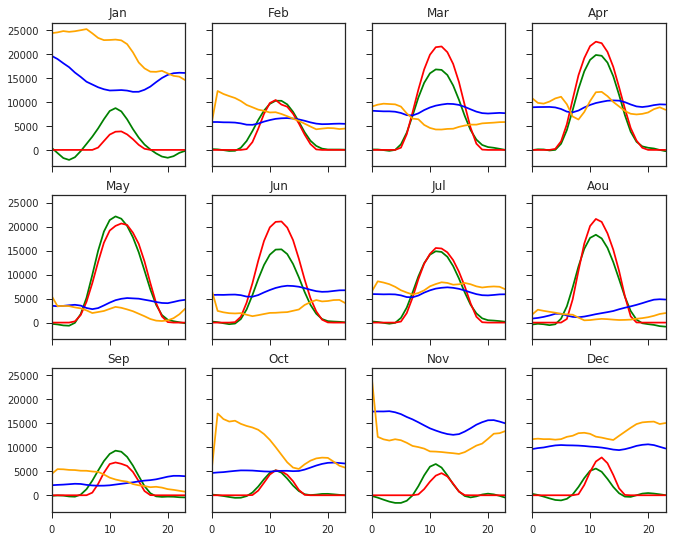

In [90]:
model = load_model('model_multivariate_50')
score_model(model)

In [91]:
score_split(model)

(1895.7519287059608, 4461.51917672829)

---

In [92]:
def create_dataset(dataset, days_look_back=1, stepsize=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-days_look_back*24-24, stepsize):
        a = np.array(dataset[i+24:(i+24+days_look_back*24)][forecast]).T.flatten()
        dataX.append(a)
        b =  np.array(dataset[i+24:(i+24+days_look_back*24)][target]).T.flatten()
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def plot_last_days(model, test_x, test_y):    
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aou", "Sep", "Oct", "Nov", "Dec"]
    prediction = model.predict(test_x)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11,9), sharey=True, sharex=True)

    for i,x in enumerate([9,18,28,37,47,56,66,76,85,95,104,113]):
        ax = pd.Series(prediction[x][0:24]).plot(ax=axes[math.floor(i/4), i%4], color="Green")
        pd.Series(test_y[x][0:24]).plot(ax=ax, color="Red")
        ax = pd.Series(prediction[x][24:48]).plot(ax=axes[math.floor(i/4), i%4], color="Blue")
        pd.Series(test_y[x][24:48]).plot(ax=ax, color="Orange")
        
        ax.title.set_text(months[i])

## ANN - Multi

Predict only from perfect weather forecast?

Train Score: 9397178.30 MSE (3065.48 RMSE)
Test Score: 10812256.70 MSE (3288.20 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='33a5ecea-6d48-4d5e-9e67-5db846e35a8e', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='44de8b12-002d-4d54-bd45-7c2584ff2d89', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='a1cf2510-b686-4167-87c0-6b12361b85e1', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='d3fee644-9551-4c58-862d-5533c702ed94', ...)


10812256.700331736

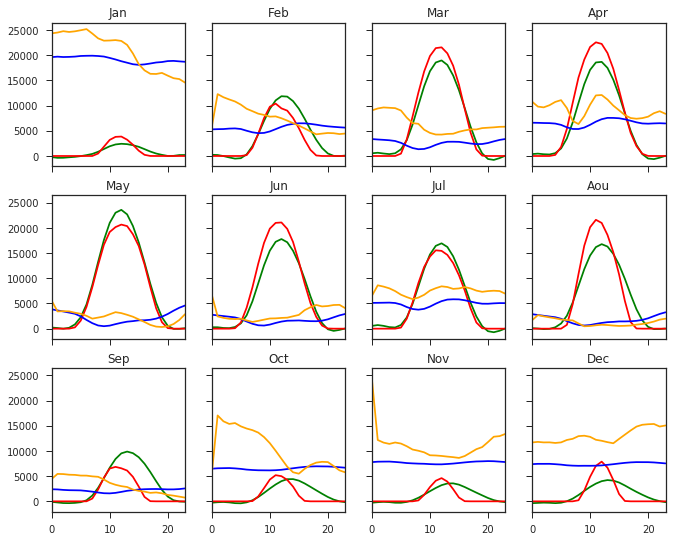

In [93]:
model = load_model('model_multivariate_from_weather_50')
score_model(model)

---

In [94]:
from keras.layers import LSTM, GRU


In [95]:
def extract_data(df, daycutoff=21):
    train = df[feature][df.index.day <= daycutoff]
    test = df[feature][df.index.day > daycutoff]
    return train, test

# convert an array of values into a dataset matrix
def create_dataset(dataset, days_look_back=1, stepsize=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-days_look_back*24-24, stepsize):
        a = dataset[i:(i+days_look_back*24)]
        dataX.append(a)
        b =  dataset[i+24:(i+24+days_look_back*24)]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

def create_prediction_data(df, daycutoff=21, 
                        days_look_back=1, stepsize=1):
    train, test = extract_data(df, daycutoff)
    train_x, train_y = create_dataset(train, days_look_back, stepsize = stepsize)
    test_x, test_y = create_dataset(pd.concat([train, test])[-len(test)-days_look_back*24-1:], 
                                    days_look_back, stepsize = stepsize)
    
    return ((train_x, train_y), (test_x, test_y))

def transform_for_lstm(a, b):
    a = np.reshape(a, (a.shape[0], 24, 1))
    b = np.reshape(b, (b.shape[0], 24, 1))
    return a, b

In [96]:
from bokeh.plotting import figure, show, output_notebook, gridplot
from bokeh.charts import Chart, Line

output_notebook()

def test_model(model, train_x, train_y, test_x, test_y):
    train_score = model.evaluate(train_x, train_y, verbose=0)
    print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
    test_score = model.evaluate(test_x, test_y, verbose=0)
    print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))
    return test_score

def plot_full(model, train_x, train_y, test_x, test_y):
    full_y = np.concatenate([train_y, test_y])
    labels_test = range(len(train_y), len(full_y))
    plt.plot(full_y)
    plt.plot(model.predict(train_x))
    plt.plot(labels_test, test_y)
    plt.plot(labels_test, model.predict(test_x))

def plot_prediction(model, test_x, test_y):
    d = pd.DataFrame(data=[test_y.flatten(), model.predict(test_x).flatten()]).T
    d.columns = ["actual", "predicted"]
    chart = Line(d, legend=True, plot_width=900, plot_height=300)
    show(chart)
    
def plot_last_days(model, test_x, test_y):    
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aou", "Sep", "Oct", "Nov", "Dec"]
    prediction = model.predict(test_x)
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(11,9), sharey=True, sharex=True)

    for i,x in enumerate([9,18,28,37,47,56,66,76,85,95,104,113]):

        ax = pd.Series(prediction[x].flatten()).plot(ax=axes[math.floor(i/4), i%4], color="Green")
        pd.Series(test_y[x][0:24].flatten()).plot(ax=ax, color="Red")
        
        ax.title.set_text(months[i])

def fit_model(model, df, days_look_back=1, nepoch=10, model_type='standard', stepsize=1):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = stepsize)
    if model_type == 'lstm':
        train_x, train_y = transform_for_lstm(train_x, train_y)
        test_x, test_y = transform_for_lstm(test_x, test_y)
    model.fit(train_x, train_y, epochs=nepoch, batch_size=10, verbose=1, validation_data=(test_x, test_y))
    return model

def score_model(model, visualize_full=False, visualize_pred=True, visualize_days=True, days_look_back=1, stepsize=1, model_type='standard'):
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = stepsize)
    if model_type == 'lstm':
        train_x, train_y = transform_for_lstm(train_x, train_y)
        test_x, test_y = transform_for_lstm(test_x, test_y)
    score = test_model(model, train_x, train_y, test_x, test_y)
    
    # For visualization take only full days 
    ((train_x, train_y), (test_x, test_y)) = create_prediction_data(df, days_look_back=days_look_back, stepsize = 24)
    if model_type == 'lstm':
        train_x, train_y = transform_for_lstm(train_x, train_y)
        test_x, test_y = transform_for_lstm(test_x, test_y)
    if visualize_full:
        plot_full(model, train_x, train_y, test_x, test_y)
    if visualize_pred:
        plot_prediction(model, test_x, test_y)
    if visualize_days:
        plot_last_days(model, test_x, test_y)
    return score

Loading BokehJS ...

## What about more hipster ANN?

RNN? LSTM? GRU?


<center> <img src="img/lstm-cell.png" style="width: 500px;"/> </center>

## LSTM

In [97]:
feature = 'DE_solar_generation'

In [98]:
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(24, return_sequences=True,
               input_shape=(24, 1)))  
model.add(LSTM(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

## LSTM - solar

Train Score: 6288368.99 MSE (2507.66 RMSE)
Test Score: 6518198.39 MSE (2553.08 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='807dd061-7a01-4f84-8263-4b069fc675ca', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='9165a29e-0040-4601-8fc7-87691276269a', ...)


6518198.394120899

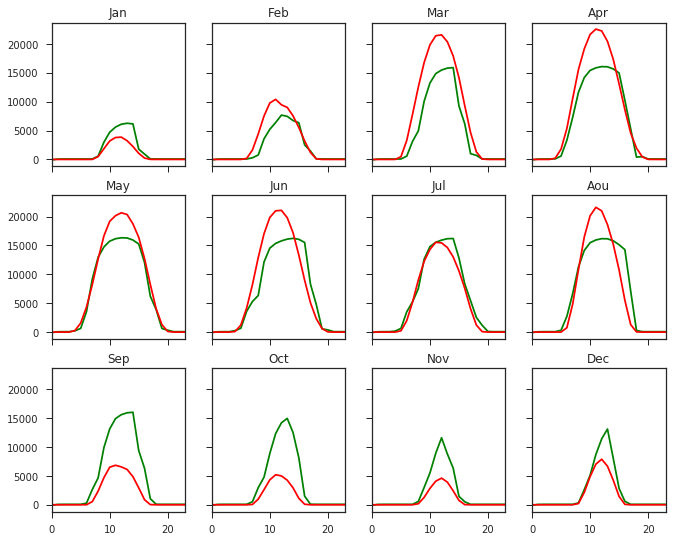

In [99]:
model = load_model('model_lstm_solar_10')
score_model(model, model_type='lstm')

## LSTM - wind

Train Score: 57655290.05 MSE (7593.11 RMSE)
Test Score: 56890590.99 MSE (7542.59 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='24d632f1-8b1c-47fe-aaef-10b9aa3f88eb', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='85d37792-6958-44b5-be86-f49933639d50', ...)


56890590.991522297

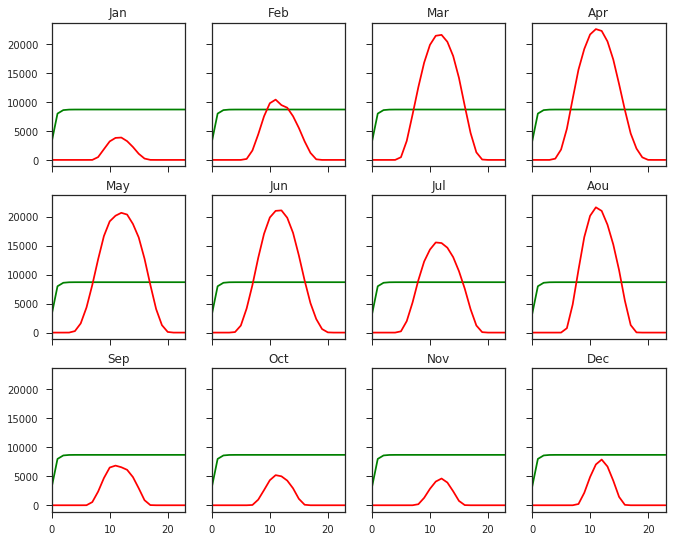

In [100]:
model = load_model('model_lstm_wind_10')
score_model(model, model_type='lstm')

## GRU

Similar to LSTM cells but simpler


<center> <img src="img/lstm-cell.png" style="width: 500px;"/> </center>

-> Even more hipster

## GRU

In [101]:
from keras.layers import GRU

model = Sequential()
model.add(GRU(24, return_sequences=True,
               input_shape=(24, 1)))  
model.add(GRU(50, return_sequences=True))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

## GRU - solar

Train Score: 7281787.44 MSE (2698.48 RMSE)
Test Score: 7778585.82 MSE (2789.01 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='893eb531-0506-4e2d-a5cf-656e005eae18', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='a0324077-97f8-47cb-8a58-57293a6235cc', ...)


7778585.8234426836

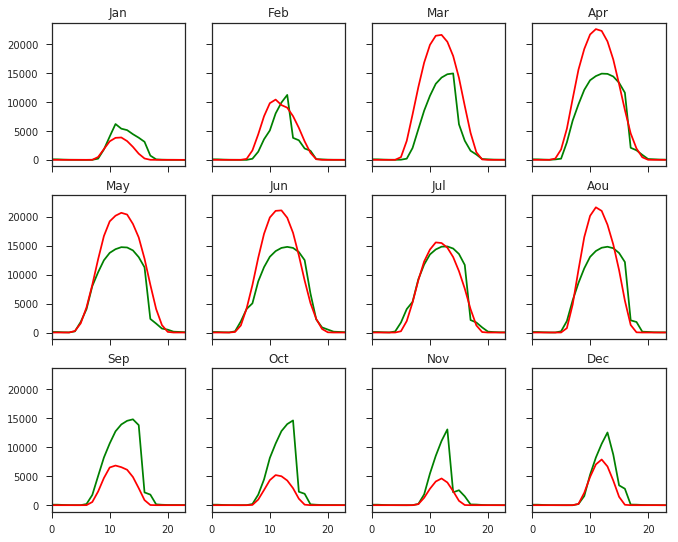

In [102]:
model = load_model('model_gru_solar_10')
score_model(model, model_type='lstm')

## GRU - wind

Train Score: 55871510.04 MSE (7474.72 RMSE)
Test Score: 55114468.35 MSE (7423.91 RMSE)


E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='8d74f934-c9bf-48a4-9fc3-72a9ec532662', ...)
E-1010 (CDSVIEW_SOURCE_DOESNT_MATCH): CDSView used by Glyph renderer must have a source that matches the Glyph renderer's data source: GlyphRenderer(id='eab8bcb5-864f-4f50-843a-634f705bf5b7', ...)


55114468.346479915

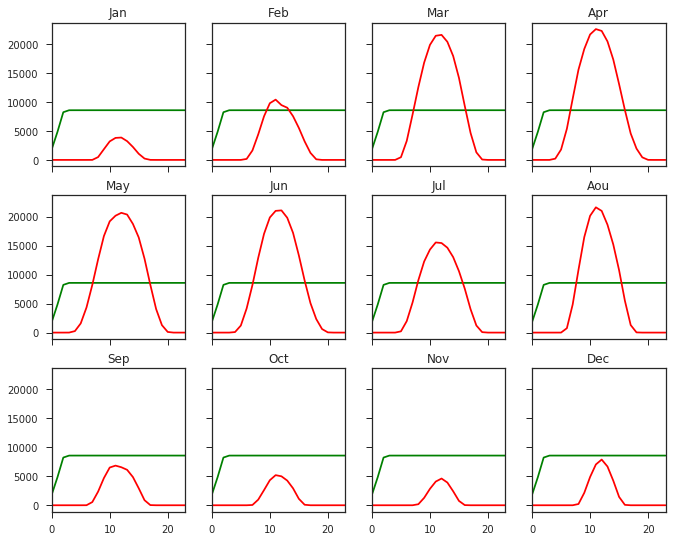

In [103]:
model = load_model('model_gru_wind_10')
score_model(model, model_type='lstm')

---

# Evaluation

## Methodology

- Train on 21 first days of each month
- Test on the rest
- We consider Solar/Wind as separate evaluations
- Measured as RMSE

# Methods considered

### Baselines

- Baseline 1: repeat the latest observation
- Baseline 2: repeat the previous day
- Baseline 3: repeat the average on the previous day

### Exponential Smoothing (ES)

- Simple Exponential Smoothing
- Double Exponential Smoothing
- Triple Exponential Smoothing, no trend
- Triple Exponential Smoothing, with trend

### ARIMA

- Auto ARIMA

### Neural networks 

- Multi-Layer Neural Network (MLP)
- MLP+Forecast
- Long-Short Term Memory Network (LSTM)

## Solar energy generation
  


- MLP + Forecast 1193.86
- MLP - Multivaritate 1895.75
- Triple ES, no trend 1906.555
- Triple ES, with trend 1918.223 
- MLP 2023.26
- Baseline 2 2046.955
- LSTM 2553.08
- GRU  2789.01
- autoARIMA 2908.358
- Baseline 3 5681.565
- Baseline 1 7277.826
- Simple ES 7277.826
- Double ES 7277.826

In [104]:
# ExpSmoothANN: Simple ES
# ExpSmoothAAN: Double ES
# ExpSmoothAAA: Triple ES, with trend
# ExpSmoothANA: Triple ES, no trend

In [105]:
solar = {'MLP + Forecast': 1193.86, 'MLP - Multivariate': 1895.75, 'Triple ES, no trend': 1906.555, 'Triple ES, with trend': 1918.223, 'MLP': 2023.26, 'Baseline 2': 2046.955,
         'LSTM': 2553.08,'GRU': 2789.01, 'autoARIMA': 2908.358, 'Baseline 3': 5681.565, 'Baseline 1': 7277.826, 
         'Simple ES': 7277.826, 'Double ES': 7277.826}

In [106]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

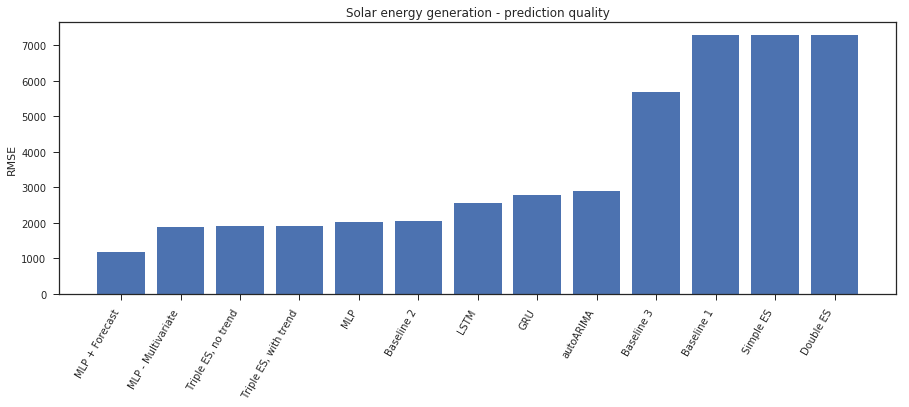

In [107]:
plt.figure(figsize=(15,5))
plt.bar(range(len(solar)), solar.values(), align='center')
plt.xticks(range(len(solar)), solar.keys(), rotation=60, ha='right')
plt.ylabel("RMSE")
plt.title("Solar energy generation - prediction quality")
plt.show()

## Wind energy generation

- MLP+Forecast 3293.83
- Double ES 4230.115
- autoARIMA 4272.435
- Baseline 1 4314.135
- Simple ES 4314.156
- Triple ES, no trend 4320.1
- Triple ES, with trend 4323.502
- MLP - Multivariate 4461.51
- MLP 4624.31
- Baseline 3 5496.671
- Baseline 2 6087.591
- GRUP  7423.91
- LSTM 7542.59

In [108]:
wind={"MLP-Forecast": 3293.83, "Double ES": 4230.115, "autoARIMA": 4272.435, "Baseline 1": 4314.135,
     "Simple ES": 4314.156, "Triple ES, no trend": 4320.1, "Triple ES, with trend": 4323.502, "MLP - Multivariate":  4461.51, "MLP": 4624.31,
     "Baseline 3": 5496.671, "Baseline 2": 6087.591, "GRU":  7423.91, "LSTM": 7542.59}

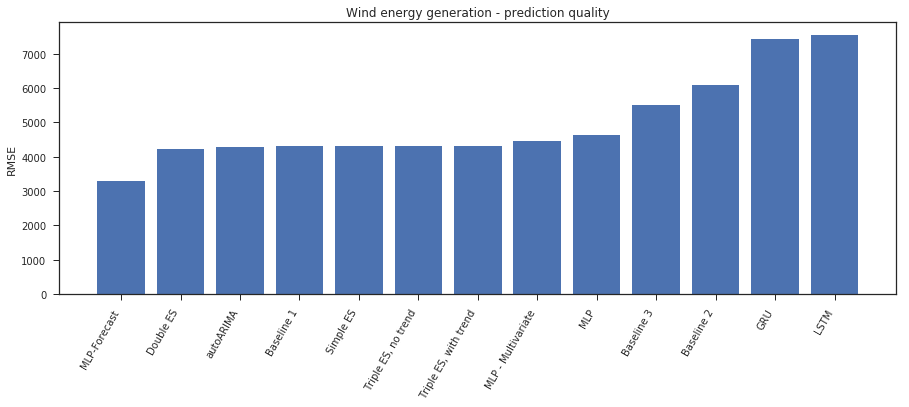

In [109]:
plt.figure(figsize=(15,5))
plt.bar(range(len(wind)), wind.values(), align='center')
plt.xticks(range(len(wind)), wind.keys(), rotation=60, ha='right')
plt.ylabel("RMSE")
plt.title("Wind energy generation - prediction quality")
plt.show()

# Discussion

- Wind is much harder to predict than Solar 
    - almost no seasonal effect
- Exponential Smoothing works quite well
    - For Solar: Triple ES, no trend
    - For Wind: Double ES
- MLP are very promissing
    - But they are difficult to tune/train
    - LSTM/GRU does not seem to work well 
- Weather prediction / external data might help a lot (if accurate)

## Summary

- Relevant libraries
- Forecasting approaches
    - Baselines
    - Smoothing
    - ARIMA
    - Neural Networks

## References

- [Tutorial RNN](https://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/)
- [Tutorial LSTM](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- De Gooijer, J. G., & Hyndman, R. J. (2006). 25 years of time series forecasting. International journal of forecasting, 22(3), 443-473
- [https://www.otexts.org/fpp](https://www.otexts.org/fpp)